In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [69]:
def generate_random_samples(batch, read = "/Users/maks/Documents/MSc_project/data/features", sequence_length = 60):
    """
    A function that creates a list of independent arrays that are to serve as samples for processing later.
    read is the directory where Excel files containing variables are stored;
    batch is the number of samples that will be generated;
    sequence length is the length of each sample.
    Returns a list of numpy arrays.
    """

    def load_excel(file_path):
        """
        Extracts sheets from Excel files given a file directory.
        """
        excel_file = pd.ExcelFile(file_path)
        
        sheets = {sheet_name: pd.read_excel(excel_file, sheet_name = sheet_name, engine = "openpyxl") for sheet_name in excel_file.sheet_names}

        return sheets
    
    def random_file(read):
        """
        Chooses a random file from a provided directory.
        """
        files = [f for f in os.listdir(read) if f.endswith(".xlsx") and not f.startswith(".")]
        
        if not files:
            raise FileNotFoundError("No Excel files found in the directory")
        
        return os.path.join(read, random.choice(files))
    
    def normalise_columns(df, columns):
        """
        Normalises specified columns between -1 and 1.
        """
        df = df.copy()  # Make a copy to avoid modifying the original DataFrame
    
        for column in columns:
            max_val = df[column].max()
            min_val = df[column].min()
            
            df.loc[:, column] = 2 * (df[column] - min_val) / (max_val - min_val) - 1

        return df

    def sampler(sheet_data, sequence_length):
        """
        Randomly creates a sample from an Excel sheet.
        sheet_data are sheets representing time series segments from where data is going to be sampled
        sequence_length is the number of points each sample will contain.
        """

        #Normalises velocities and angular velocities using normalise_columns
        columns = ["velocity_x", "velocity_y", "velocity_z", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]
        sheet_data = normalise_columns(sheet_data, columns)

        num_points = len(sheet_data)

        if num_points < sequence_length + 2:
            return None
        
        start_index = random.randint(2, num_points - sequence_length)
        end_index = start_index + sequence_length
        sample = sheet_data.iloc[start_index : end_index].to_numpy()

        return sample #Transposes the samle to switch rows and columns
    
    def weighted_random_choice(sheets):
        """
        Assigns weights to sheets based on the length of each sheet.
        """
        total_points = sum(len(data) for data in sheets.values())
        weights = [len(data) / total_points for data in sheets.values()]

        return random.choices(list(sheets.keys()), weights = weights, k = 1)[0]
    
    #Initializes list to strore sample arrays
    samples = []

    while len(samples) < batch:
        file_path = random_file(read)
        sheets = load_excel(file_path)

        while len(samples) < batch:
            sheet_name = weighted_random_choice(sheets)
            sheet_data = sheets[sheet_name][["velocity_x", "velocity_y", "velocity_z", "tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]]
            sample = sampler(sheet_data, sequence_length)

            if sample is not None:
                samples.append(sample)

            #Stops once batch size is reached
            if len(samples) >= batch:
                break

    return samples

In [70]:
#Class to contain our sampled time series data
class TimeSeriesData(Dataset):
    def __init__(self, no_samples):
        self.data = generate_random_samples(no_samples)
        self.data = np.array(self.data)

        self.data = torch.tensor(self.data, dtype = torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        return self.data[i]
    

In [71]:
class BranchingAE(nn.Module):
    def __init__(self):
        super(BranchingAE, self).__init__()

        #Branch for velocities (first 3 features)
        self.velocity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Branch for tortuosity (4th feature)
        self.tortuosity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Branch for angular velocities (last 3 features (out of 7))
        self.ang_velocity_branch = nn.Sequential(
            nn.Conv1d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2),

            nn.Conv1d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU(),
            nn.MaxPool1d(kernel_size = 2, stride = 2)
        )

        #Shared decoder for merging the features
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels = 192, out_channels = 128, kernel_size = 2, stride = 2),
            nn.ELU(),

            nn.ConvTranspose1d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2),
            nn.ELU(),

            nn.ConvTranspose1d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
            nn.ELU()
        )

        #Output layers for different variables
        self.output_velocity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

        self.output_tortuosity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 1, kernel_size = 3, stride = 1, padding = 1)
        )

        self.output_ang_velocity = nn.Sequential(
            nn.Conv1d(in_channels = 32, out_channels = 3, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

    def forward(self, x):

        #print("Input shape:", x.shape)

        velocity = x[:, :, :3]
        tortuosity = x[:, :, 3:4]
        ang_velocity = x[:, :, 4:]

        #print("Velocity shape:", velocity.shape)
        #print("Tortuosity shape:", tortuosity.shape)
        #print("Angular velocity shape:", ang_velocity.shape)

        velocity = velocity.permute(0, 2, 1)
        tortuosity = tortuosity.permute(0, 2, 1)
        ang_velocity = ang_velocity.permute(0, 2, 1)

        #print("Permuted elocity shape:", velocity.shape)
        #print("permuted tortuosity shape:", tortuosity.shape)
        #print("Permuted angular velocity shape:", ang_velocity.shape)

        #Permutes to desired shape
        velocity_encoded = self.velocity_branch(velocity)
        tortuosity_encoded = self.tortuosity_branch(tortuosity)
        ang_velocity_encoded = self.ang_velocity_branch(ang_velocity)

        #print("Velocity encoded shape:", velocity_encoded.shape)
        #print("Tortuosity encoded shape:", tortuosity_encoded.shape)
        #print("Angular velocity encoded shape:", ang_velocity_encoded.shape)

        #Concatenates encoded features
        combined_encoded = torch.cat((velocity_encoded, tortuosity_encoded, ang_velocity_encoded), dim = 1)

        #print("Combined encoded shape:", combined_encoded.shape)

        #Decodes combined features
        decoded = self.decoder(combined_encoded)

        #print("Decoded shape:", decoded.shape)

        #Generates outputs for each set of variables
        velocity_output = self.output_velocity(decoded)
        tortuosity_output = self.output_tortuosity(decoded)
        ang_velocity_output = self.output_ang_velocity(decoded)

        #print("Velocity output shape:", velocity_output.shape)
        #print("Tortuosity output shape:", tortuosity_output.shape)
        #print("Angular velocity output shape:", ang_velocity_output.shape)  

        #Concatenates all outputs
        combined_output = torch.cat((velocity_output, tortuosity_output, ang_velocity_output), dim = 1)
        
        #print("Combined output shape:", combined_output.shape)

        #Permutes back
        output = combined_output.permute(0, 2, 1)
        
        #print("Final output shape:", output.shape)

        return output
    
    def encode(self, x):

        velocity = x[:, :, :3]
        tortuosity = x[:, :, 3:4]
        ang_velocity = x[:, :, 4:]

        velocity = velocity.permute(0, 2, 1)
        tortuosity = tortuosity.permute(0, 2, 1)
        ang_velocity = ang_velocity.permute(0, 2, 1)

        #Permutes to desired shape
        velocity_encoded = self.velocity_branch(velocity)
        tortuosity_encoded = self.tortuosity_branch(tortuosity)
        ang_velocity_encoded = self.ang_velocity_branch(ang_velocity)

        #Concatenates encoded features
        combined_encoded = torch.cat((velocity_encoded, tortuosity_encoded, ang_velocity_encoded), dim = 1)

        return combined_encoded



In [72]:
#Dataset and dataloader parameters
no_samples = 480
batch_size = 32

In [73]:
#Model, loss function and optimiser
model = BranchingAE()
criterion = nn.SmoothL1Loss()
optimiser = optim.AdamW(model.parameters(), lr = 0.00075)
max_gradient_norm = 0.66

In [74]:
#Training loop
no_episodes = 50
epochs = 15
#os.makedirs("/Users/maks/Documents/MSc_project/data/hidden_layer_representations/day_1", exist_ok = True)

for episode in range(no_episodes):
    print(f"Starting episode {episode + 1}/{no_episodes}")

    #Generates dataset
    dataset = TimeSeriesData(no_samples)
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

    #Records start time for an episode
    start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_data in dataloader:
            #Forward pass
            output = model(batch_data)
            #if output is None:
                #print("Model output is None.")
            #else:
                #print("Model output shape:", output.shape)

            loss = criterion(output, batch_data)

            #Backward pass
            optimiser.zero_grad()
            loss.backward()

            #Gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), max_gradient_norm)

            #Optimisation step
            optimiser.step()

            epoch_loss += loss.item()

        average_epoch_loss = epoch_loss / len(dataloader)
        print(f"Episode {episode + 1 }, epoch [{epoch + 1}/{epochs}], loss: {average_epoch_loss}")

    #Records end time of the episode
    end_time = time.time()

    #Prints duration of the episode
    runtime = end_time - start_time
    print(f"Episode {episode + 1} completed in {runtime:.2f} seconds")

    #Saves hidden layer representation every 10 episodes
    if (episode + 1) % 10 == 0:
        hidden_representations = []
        for batch_data in dataloader:
            with torch.no_grad():
                hidden_repr = model.encode(batch_data)
                hidden_representations.append(hidden_repr.numpy())

        hidden_representations = np.concatenate(hidden_representations, axis = 0)
        np.save(f"/Users/maks/Documents/MSc_project/data/hidden_layer_representations/day_1/hidden_representations_episode_{episode + 1}.npy", hidden_representations)
        print(f"Saved hidden representations for episode {episode + 1}")

print("Training finished!")

Starting episode 1/50
Episode 1, epoch [1/15], loss: 1.3247406284014385
Episode 1, epoch [2/15], loss: 0.578057050704956
Episode 1, epoch [3/15], loss: 0.24195700585842134
Episode 1, epoch [4/15], loss: 0.16077732940514883
Episode 1, epoch [5/15], loss: 0.1478707214196523
Episode 1, epoch [6/15], loss: 0.13093696907162666
Episode 1, epoch [7/15], loss: 0.1173520840704441
Episode 1, epoch [8/15], loss: 0.10650137787063917
Episode 1, epoch [9/15], loss: 0.10824156900246938
Episode 1, epoch [10/15], loss: 0.09672407781084379
Episode 1, epoch [11/15], loss: 0.09194746762514114
Episode 1, epoch [12/15], loss: 0.08604138170679411
Episode 1, epoch [13/15], loss: 0.0678807287166516
Episode 1, epoch [14/15], loss: 0.06120394828418891
Episode 1, epoch [15/15], loss: 0.062248243888219194
Episode 1 completed in 17.61 seconds
Starting episode 2/50
Episode 2, epoch [1/15], loss: 18778589321.24274
Episode 2, epoch [2/15], loss: 13231881148.420864
Episode 2, epoch [3/15], loss: 13763418522.261993
Epis

In [87]:
variable_names = ["Velocity x", "Velocity y", "Velocity z", "Tortuosity 3d", "Angular Velocity yz", "Angular Velocity xz", "Angular Velocity xy"]

#Visualising reconstructed data
def plot_reconstruction(original, reconstructed, n = 5):
    
    plt.figure(figsize = (15, 10))

    for i in range(n):
        for j in range(7):
            ax = plt.subplot(n, 7, i * 7 + j + 1)
            plt.plot(original[i][:, j].numpy(), label = "Original")
            plt.plot(reconstructed[i][:, j].detach().numpy(), label = "Reconstructed")
            
            if j == 0:
                ax.set_ylabel(f"Sample {i + 1}")
            if i == 0:
                ax.set_title(variable_names[j])
            if i == n - 1 and j == 2:
                ax.legend()

    plt.subplots_adjust(wspace=0.35, hspace=0.35)
    
    plt.show()

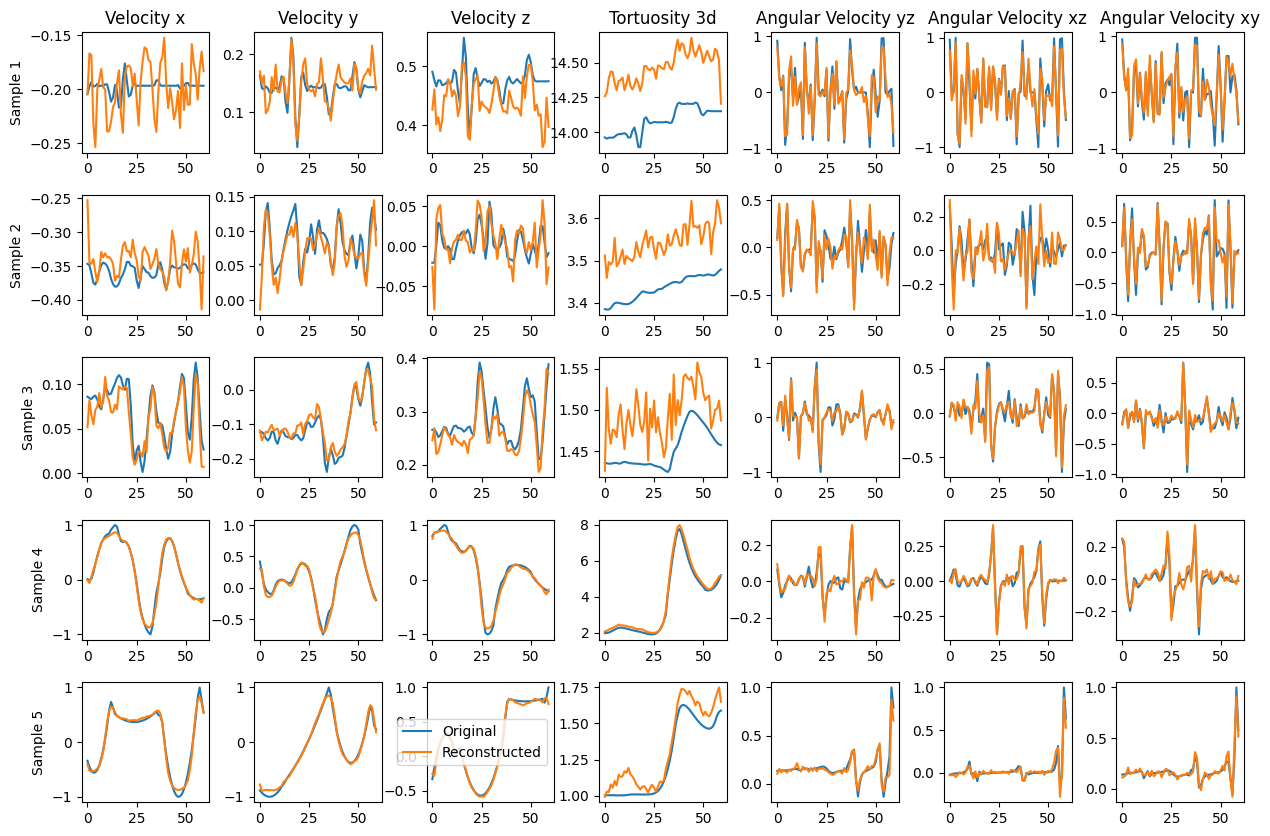

In [88]:
test_data = next(iter(dataloader))
reconstructed_data = model(test_data)

plot_reconstruction(test_data, reconstructed_data)

In [90]:
write1 = "/Users/maks/Documents/MSc_project/data/models/branching_ae_test3.pth"

torch.save(model.state_dict(), write1)
print(f"Model saved to {write1}")

Model saved to /Users/maks/Documents/MSc_project/data/models/branching_ae_test3.pth
